In [61]:
import pandas as pd
import numpy as np
import os
import getpass
import re
import nltk
import tqdm
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import swifter
import matplotlib as plt
import matplotlib.pyplot as plt 
import os
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from keras import optimizers
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from flaml import AutoML

In [62]:
df = pd.read_csv("Merged_Finall.csv")
df = df[df["Date"] > "2014-01-01"]
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(by="Date")

In [63]:
df["prev_close"] = df["Close"].shift(+1)
df["prev2_close"] = df["Close"].shift(+2)
df["prev3_close"] = df["Close"].shift(+3)
df["prev4_close"] = df["Close"].shift(+4)
df["prev5_close"] = df["Close"].shift(+5)
df = df[["Date", "Open", "High", "Low", "Volume", "FinalScore", "prev_close", "prev2_close", "prev3_close", "prev4_close", "prev5_close", "Close"]]
df = df.dropna()

In [64]:
df

,Date,Open,High,Low,Volume,FinalScore,prev_close,prev2_close,prev3_close,prev4_close,prev5_close,Close
253,2014-01-07,946.489990,965.739990,802.000000,8.131170e+07,0.137522,953.289978,933.530029,859.510010,818.719971,802.390015,802.000000
254,2014-01-08,795.989990,870.679993,776.179993,7.417560e+07,0.118022,802.000000,953.289978,933.530029,859.510010,818.719971,842.719971
255,2014-01-09,841.469971,864.359985,804.140015,5.999860e+07,0.152745,842.719971,802.000000,953.289978,933.530029,859.510010,846.859985
256,2014-01-10,846.690002,871.190002,822.599976,3.187680e+07,0.163590,846.859985,842.719971,802.000000,953.289978,933.530029,868.479980
257,2014-01-11,867.320007,921.479980,861.719971,4.475420e+07,0.161135,868.479980,846.859985,842.719971,802.000000,953.289978,913.950012
...,...,...,...,...,...,...,...,...,...,...,...,...
2395,2019-11-19,8305.134291,8408.516128,8099.963369,2.108361e+10,266.234714,8309.285983,8577.975782,8550.760557,8491.992012,8708.095095,8206.145918
2396,2019-11-20,8203.613180,8237.239874,8010.511901,2.076430e+10,10.221575,8206.145918,8309.285983,8577.975782,8550.760557,8491.992012,8027.268243
2397,2019-11-21,8023.644687,8110.098131,7597.381608,2.251424e+10,-8503.435071,8027.268243,8206.145918,8309.285983,8577.975782,8550.760557,7642.749945
2398,2019-11-22,7643.569425,7697.382714,6936.706599,3.424232e+10,15.649639,7642.749945,8027.268243,8206.145918,8309.285983,8577.975782,7296.577568


In [65]:
X_with_dates = df.iloc[:,:-1] #all columns but not close
y = df.iloc[:, -1] #close

In [66]:
X_train_with_dates, X_test_with_dates, y_train, y_test = train_test_split(X_with_dates, y, test_size=0.3, random_state=42, shuffle=False)

X_train_with_dates = X_train_with_dates.reset_index(drop=True)
X_test_with_dates = X_test_with_dates.reset_index(drop=True)

In [67]:
X_train = X_train_with_dates[["Open", "High", "Low", "Volume", "prev_close", "prev2_close", "prev3_close", "prev4_close", "prev5_close"]]
X_test = X_test_with_dates[["Open", "High", "Low", "Volume", "prev_close", "prev2_close", "prev3_close", "prev4_close", "prev5_close"]]

y_train = np.array(y_train)
y_test = np.array(y_test)

In [68]:
scaler = StandardScaler().fit(X_train)

X_train_sc = scaler.transform(X_train)

X_test_sc = scaler.transform(X_test)

In [69]:
X_train_ds = pd.DataFrame(X_train_sc)
X_train_ds["Date"] = X_train_with_dates["Date"]


X_test_ds = pd.DataFrame(X_test_sc)
X_test_ds["Date"] = X_test_with_dates["Date"]

In [70]:
X_train_ds = X_train_ds[["Date", 0, 1, 2, 3, 4, 5, 6, 7, 8]]
X_test_ds = X_test_ds[["Date", 0, 1, 2, 3, 4, 5, 6, 7, 8]]

In [71]:
automl = AutoML()

In [72]:
automl.fit(X_train=X_train_ds,  # a single column of timestamp
           y_train=y_train,  # value for each timestamp
           period=1,  # time horizon to forecast, e.g., 12 months
           task='ts_forecast', time_budget=60,  # time budget in seconds
           log_file_name="ts_forecast.log",
          )

[flaml.automl: 12-14 14:31:34] {1943} INFO - task = ts_forecast
[flaml.automl: 12-14 14:31:34] {1945} INFO - Data split method: time
[flaml.automl: 12-14 14:31:34] {1949} INFO - Evaluation method: cv
[flaml.automl: 12-14 14:31:34] {2019} INFO - Minimizing error metric: mape
[flaml.automl: 12-14 14:31:34] {2071} INFO - List of ML learners in AutoML Run: ['arima', 'sarimax']
[flaml.automl: 12-14 14:31:34] {2311} INFO - iteration 0, current learner arima


2018-02-12 00:00:00 2018-02-12 00:00:00 (1, 9)
2018-02-13 00:00:00 2018-02-13 00:00:00 (1, 9)
2018-02-14 00:00:00 2018-02-14 00:00:00 (1, 9)
2018-02-15 00:00:00 2018-02-15 00:00:00 (1, 9)


[flaml.automl: 12-14 14:31:37] {2424} INFO - Estimated sufficient time budget=36510s. Estimated necessary time budget=37s.
[flaml.automl: 12-14 14:31:37] {2499} INFO -  at 3.7s,	estimator arima's best error=0.0268,	best estimator arima's best error=0.0268
[flaml.automl: 12-14 14:31:37] {2311} INFO - iteration 1, current learner arima


2018-02-16 00:00:00 2018-02-16 00:00:00 (1, 9)
2018-02-12 00:00:00 2018-02-12 00:00:00 (1, 9)
2018-02-13 00:00:00 2018-02-13 00:00:00 (1, 9)
2018-02-14 00:00:00 2018-02-14 00:00:00 (1, 9)
2018-02-15 00:00:00 2018-02-15 00:00:00 (1, 9)


[flaml.automl: 12-14 14:31:44] {2499} INFO -  at 10.4s,	estimator arima's best error=0.0268,	best estimator arima's best error=0.0268
[flaml.automl: 12-14 14:31:44] {2311} INFO - iteration 2, current learner sarimax


2018-02-16 00:00:00 2018-02-16 00:00:00 (1, 9)
2018-02-12 00:00:00 2018-02-12 00:00:00 (1, 9)
2018-02-13 00:00:00 2018-02-13 00:00:00 (1, 9)
2018-02-14 00:00:00 2018-02-14 00:00:00 (1, 9)
2018-02-15 00:00:00 2018-02-15 00:00:00 (1, 9)


[flaml.automl: 12-14 14:31:48] {2499} INFO -  at 13.9s,	estimator sarimax's best error=0.0268,	best estimator arima's best error=0.0268
[flaml.automl: 12-14 14:31:48] {2311} INFO - iteration 3, current learner sarimax


2018-02-16 00:00:00 2018-02-16 00:00:00 (1, 9)
2018-02-12 00:00:00 2018-02-12 00:00:00 (1, 9)
2018-02-13 00:00:00 2018-02-13 00:00:00 (1, 9)
2018-02-14 00:00:00 2018-02-14 00:00:00 (1, 9)
2018-02-15 00:00:00 2018-02-15 00:00:00 (1, 9)


[flaml.automl: 12-14 14:31:55] {2499} INFO -  at 21.4s,	estimator sarimax's best error=0.0268,	best estimator arima's best error=0.0268
[flaml.automl: 12-14 14:31:55] {2311} INFO - iteration 4, current learner arima


2018-02-16 00:00:00 2018-02-16 00:00:00 (1, 9)
2018-02-12 00:00:00 2018-02-12 00:00:00 (1, 9)
2018-02-13 00:00:00 2018-02-13 00:00:00 (1, 9)
2018-02-14 00:00:00 2018-02-14 00:00:00 (1, 9)
2018-02-15 00:00:00 2018-02-15 00:00:00 (1, 9)


[flaml.automl: 12-14 14:31:59] {2499} INFO -  at 25.4s,	estimator arima's best error=0.0167,	best estimator arima's best error=0.0167
[flaml.automl: 12-14 14:31:59] {2311} INFO - iteration 5, current learner arima


2018-02-16 00:00:00 2018-02-16 00:00:00 (1, 9)
2018-02-12 00:00:00 2018-02-12 00:00:00 (1, 9)
2018-02-13 00:00:00 2018-02-13 00:00:00 (1, 9)
2018-02-14 00:00:00 2018-02-14 00:00:00 (1, 9)
2018-02-15 00:00:00 2018-02-15 00:00:00 (1, 9)


[flaml.automl: 12-14 14:32:03] {2499} INFO -  at 29.3s,	estimator arima's best error=0.0167,	best estimator arima's best error=0.0167
[flaml.automl: 12-14 14:32:03] {2311} INFO - iteration 6, current learner arima


2018-02-16 00:00:00 2018-02-16 00:00:00 (1, 9)
2018-02-12 00:00:00 2018-02-12 00:00:00 (1, 9)
2018-02-13 00:00:00 2018-02-13 00:00:00 (1, 9)
2018-02-14 00:00:00 2018-02-14 00:00:00 (1, 9)
2018-02-15 00:00:00 2018-02-15 00:00:00 (1, 9)


[flaml.automl: 12-14 14:32:08] {2499} INFO -  at 34.4s,	estimator arima's best error=0.0103,	best estimator arima's best error=0.0103
[flaml.automl: 12-14 14:32:08] {2311} INFO - iteration 7, current learner arima


2018-02-16 00:00:00 2018-02-16 00:00:00 (1, 9)
2018-02-12 00:00:00 2018-02-12 00:00:00 (1, 9)
2018-02-13 00:00:00 2018-02-13 00:00:00 (1, 9)
2018-02-14 00:00:00 2018-02-14 00:00:00 (1, 9)
2018-02-15 00:00:00 2018-02-15 00:00:00 (1, 9)


[flaml.automl: 12-14 14:32:14] {2499} INFO -  at 40.3s,	estimator arima's best error=0.0103,	best estimator arima's best error=0.0103
[flaml.automl: 12-14 14:32:14] {2311} INFO - iteration 8, current learner arima


2018-02-16 00:00:00 2018-02-16 00:00:00 (1, 9)
2018-02-12 00:00:00 2018-02-12 00:00:00 (1, 9)
2018-02-13 00:00:00 2018-02-13 00:00:00 (1, 9)
2018-02-14 00:00:00 2018-02-14 00:00:00 (1, 9)
2018-02-15 00:00:00 2018-02-15 00:00:00 (1, 9)


[flaml.automl: 12-14 14:32:18] {2499} INFO -  at 44.4s,	estimator arima's best error=0.0103,	best estimator arima's best error=0.0103
[flaml.automl: 12-14 14:32:18] {2311} INFO - iteration 9, current learner arima


2018-02-16 00:00:00 2018-02-16 00:00:00 (1, 9)
2018-02-12 00:00:00 2018-02-12 00:00:00 (1, 9)
2018-02-13 00:00:00 2018-02-13 00:00:00 (1, 9)
2018-02-14 00:00:00 2018-02-14 00:00:00 (1, 9)
2018-02-15 00:00:00 2018-02-15 00:00:00 (1, 9)


[flaml.automl: 12-14 14:32:23] {2499} INFO -  at 49.6s,	estimator arima's best error=0.0103,	best estimator arima's best error=0.0103
[flaml.automl: 12-14 14:32:23] {2311} INFO - iteration 10, current learner arima


2018-02-16 00:00:00 2018-02-16 00:00:00 (1, 9)
2018-02-12 00:00:00 2018-02-12 00:00:00 (1, 9)
2018-02-13 00:00:00 2018-02-13 00:00:00 (1, 9)
2018-02-14 00:00:00 2018-02-14 00:00:00 (1, 9)
2018-02-15 00:00:00 2018-02-15 00:00:00 (1, 9)


[flaml.automl: 12-14 14:32:28] {2499} INFO -  at 54.2s,	estimator arima's best error=0.0103,	best estimator arima's best error=0.0103
[flaml.automl: 12-14 14:32:28] {2311} INFO - iteration 11, current learner sarimax


2018-02-16 00:00:00 2018-02-16 00:00:00 (1, 9)
2018-02-12 00:00:00 2018-02-12 00:00:00 (1, 9)
2018-02-13 00:00:00 2018-02-13 00:00:00 (1, 9)
2018-02-14 00:00:00 2018-02-14 00:00:00 (1, 9)
2018-02-15 00:00:00 2018-02-15 00:00:00 (1, 9)


[flaml.automl: 12-14 14:32:32] {2499} INFO -  at 58.2s,	estimator sarimax's best error=0.0167,	best estimator arima's best error=0.0103


2018-02-16 00:00:00 2018-02-16 00:00:00 (1, 9)


[flaml.automl: 12-14 14:32:33] {2715} INFO - retrain arima for 1.1s
[flaml.automl: 12-14 14:32:33] {2722} INFO - retrained model: <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x7fcc01880400>
[flaml.automl: 12-14 14:32:33] {2100} INFO - fit succeeded
[flaml.automl: 12-14 14:32:33] {2101} INFO - Time taken to find the best model: 34.4445595741272


In [73]:
pred = automl.predict(X_test_ds)

2018-02-17 00:00:00 2019-11-23 00:00:00 (645, 9)


In [74]:
a = list(pred)

In [75]:
X_test_ds["actual"] = y_test
X_test_ds["prediction"] = a

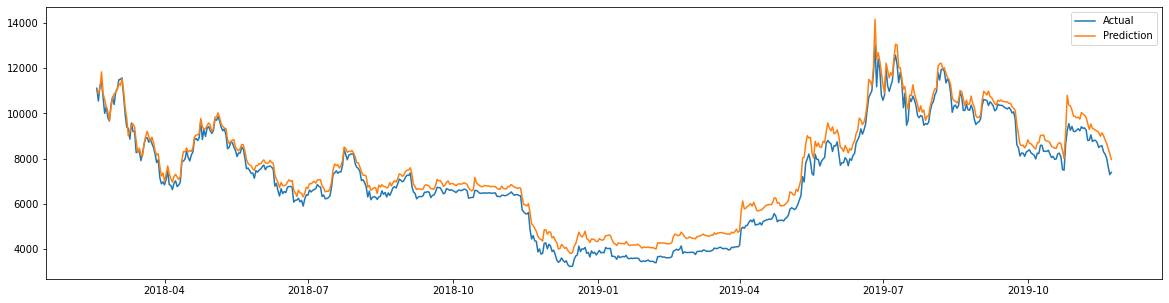

In [82]:
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(X_test_ds["Date"], X_test_ds["actual"], label = "Actual")
plt.plot(X_test_ds["Date"], X_test_ds["prediction"], label = "Prediction")
plt.legend()

In [95]:
X_test_ds_ = X_test_ds[X_test_ds["Date"] >= "2018-09-20"]

In [97]:
merged_df = X_test_ds_[["Date", "actual", "prediction"]]

merged_df["Actual_prev"] = merged_df["actual"].shift(+1)
merged_df["Pred_prev"] = merged_df["prediction"].shift(+1)
merged_df = merged_df.dropna()

In [98]:
merged_df['Actual_target'] = merged_df[['actual','Actual_prev']].apply(lambda x: 1 if x.actual > x.Actual_prev else 0, axis=1)
merged_df['Pred_target'] = merged_df[['prediction','Pred_prev']].apply(lambda x: 1 if x.prediction > x.Pred_prev else 0, axis=1)

In [99]:
act = list(merged_df["Actual_target"])
pred = list(merged_df["Pred_target"])

In [100]:
hit = 0
miss = 0
for i in range(len(act)):
    if act[i] == pred[i]:
        hit+=1
    else:
        miss+=1
print(f"total hits are {hit} and total misses are {miss}")

total hits are 326 and total misses are 103


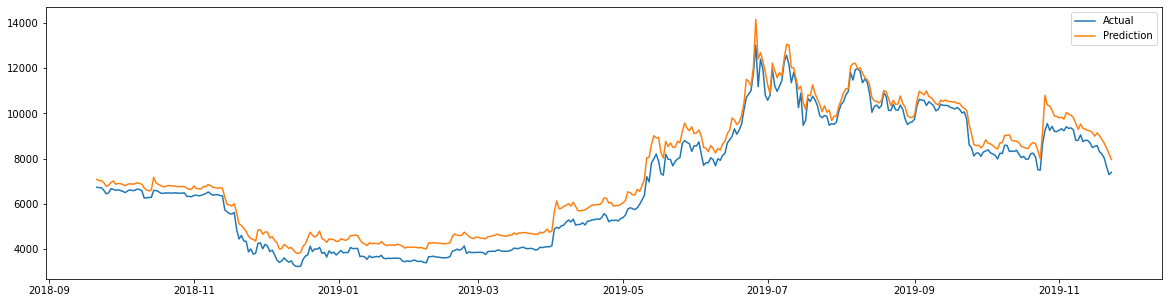

In [101]:
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(merged_df["Date"], merged_df["actual"], label = "Actual")
plt.plot(merged_df["Date"], merged_df["prediction"], label = "Prediction")
plt.legend()

In [93]:
X_train_ds

,Date,0,1,2,3,4,5,6,7,8
0,2014-01-07,-0.229318,-0.232172,-0.269612,-0.302633,-0.227094,-0.232048,-0.254598,-0.266546,-0.270576
1,2014-01-08,-0.277716,-0.261332,-0.278436,-0.305031,-0.275754,-0.225677,-0.230681,-0.253344,-0.265281
2,2014-01-09,-0.263091,-0.263271,-0.268881,-0.309797,-0.262657,-0.274458,-0.224296,-0.229388,-0.252055
3,2014-01-10,-0.261412,-0.261176,-0.262572,-0.319250,-0.261326,-0.261328,-0.273180,-0.222992,-0.228054
4,2014-01-11,-0.254778,-0.245749,-0.249204,-0.314921,-0.254372,-0.259993,-0.260023,-0.271958,-0.221647
...,...,...,...,...,...,...,...,...,...,...
1497,2018-02-12,2.084416,2.228098,2.238556,1.773060,2.081174,2.246943,2.290736,2.143651,1.940424
1498,2018-02-13,2.336948,2.219677,2.345855,1.584917,2.337388,2.088328,2.253552,2.296217,2.149332
1499,2018-02-14,2.231856,2.391484,2.395240,2.328823,2.231808,2.345179,2.094602,2.258971,2.302178
1500,2018-02-15,2.517546,2.611204,2.667148,2.716296,2.520096,2.239337,2.351996,2.099757,2.264864


In [94]:
X_test_ds

,Date,0,1,2,3,4,5,6,7,8,actual,prediction
0,2018-02-17,2.748818,2.888730,2.924758,2.581283,2.757871,2.744942,2.535545,2.251336,2.363652,11112.700195,10971.301945
1,2018-02-18,3.043352,2.953242,2.985109,2.609225,3.040523,2.766707,2.752604,2.541432,2.257215,10551.799805,10884.493640
2,2018-02-19,2.859795,2.929928,3.049082,2.242190,2.860118,3.050062,2.774415,2.758852,2.547843,11225.299805,11104.722396
3,2018-02-20,3.078210,3.139966,3.294656,3.006718,3.076739,2.869208,3.058369,2.780699,2.765661,11403.700195,11837.337103
4,2018-02-21,3.123360,2.974316,3.037429,2.831523,3.134119,3.086367,2.877133,3.065125,2.787548,10690.400391,10883.179012
...,...,...,...,...,...,...,...,...,...,...,...,...
640,2019-11-19,2.137059,2.050974,2.224385,6.757030,2.138848,2.232780,2.230566,2.216926,2.292812,8206.145918,8840.954732
641,2019-11-20,2.104412,1.998433,2.193816,6.649697,2.105675,2.146146,2.239360,2.235947,2.222742,8027.268243,8688.107136
642,2019-11-21,2.046539,1.959431,2.052634,7.237918,2.048142,2.112890,2.152542,2.244755,2.241797,7642.749945,8461.453500
643,2019-11-22,1.924315,1.832826,1.826855,11.180164,1.924467,2.055214,2.119215,2.157793,2.250622,7296.577568,8220.887187
